In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
import os
import scipy.optimize as sc
import matplotlib as mpl
import glob
from matplotlib.path import Path
from collections import Counter
from tqdm import tqdm


### idea to code improvements:
make it so the beginning of file needs specifying what isotope and what peaks we are interested in then running this file should generate an instantation of a class object holding every piece of information that one can get out by a few simple commands
That would be the most ideal i think. In stead of generating everything like this. I could make a separate file that handles some of the most basic functions, even just make definitions.

I should have:
plot_hitpattern(list_of_fi,list_of_bi)
plot_banana()
plot_energyspec
and so on

It would be really nice if i made a function, in here or in some other document where it is easy to specify a plot such that i dont have to waste so many lines of code of copying, this can be made a lot tighter


In [2]:

## Hardcoded data paths are not ideal but whatever for now

datapath = "/home/haue/repositories/Masters/data/"
iso = "Si" 
_path = datapath + "bananas/" + iso
#_p_path = datapath +"bananaexplorer/" +iso
simpath = "/home/haue/repositories/Masters/simdata/"

#outputdir = "/home/haue/repositories/Masters/analysis/python/dataquality/report_figs/"

_files = glob.glob(os.path.join(_path, "*mlio.root"))
#_p_file = glob.glob(os.path.join(_p_path, "*mlio.root"))

In [3]:
#### Loading in of the data files storing them in a dictionary can be easily expanded to include multiple isotopes
#Could be done more optimally by doing it dynamically instead of this?
data_files = {
    iso: _files,
    #"p_"+iso: _p_file,
}
data_collection = {
    iso : {},
    #"p_"+iso : {}
}

data_collection = {isotope: {f"id{i}": {key: [] for key in ["E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ",
                                                            "tarpos.fX", "tarpos.fY", "tarpos.fZ"]} for i in range(6)} for isotope in data_files}

for isotope, files in data_files.items():
    file_progress = tqdm(files, desc=f"Processing {isotope}", unit="file", total=len(files), bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

    for file in file_progress:
        
        ## accesses the tree "a" in the root file
        r = uproot.open(file)["a"]
        ##Dummy array
        if isotope=="p_"+iso:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ","tarpos.fX", "tarpos.fY", "tarpos.fZ"])
            xtar = ak.nan_to_num(ak.flatten(dum["tarpos.fX"]))
            ytar = ak.nan_to_num(ak.flatten(dum["tarpos.fY"]))
            ztar = ak.nan_to_num(ak.flatten(dum["tarpos.fZ"]))
        else:
            dum = r.arrays(["id", "E", "fEdep", "bEdep", "angle", "Edep", "FI", "BI", "pos.fX", "pos.fY", "pos.fZ"])
        ## converts it to an awkward array
        ids = ak.flatten(dum["id"])
        Es = ak.nan_to_num(ak.flatten(dum["E"]) / 1e3)
        fEdeps = ak.nan_to_num(ak.flatten(dum["fEdep"]) / 1e3)
        bEdeps = ak.nan_to_num(ak.flatten(dum["bEdep"]) / 1e3)
        angles = ak.nan_to_num(np.rad2deg(ak.flatten(dum["angle"])))
        Edeps = ak.nan_to_num(ak.flatten(dum["Edep"]) / 1e3)
        FIs = ak.flatten(dum["FI"])
        BIs = ak.flatten(dum["BI"])
        xpos = ak.flatten(dum["pos.fX"])
        ypos = ak.flatten(dum["pos.fY"])
        zpos = ak.flatten(dum["pos.fZ"])
        ##Creates entries in data_collection for each key and for each detector for each key
        for i in range(6):
            mask = (ids==i)
            detector_name = f"id{i}"
            data_collection[isotope][detector_name]["E"].extend(Es[mask])
            data_collection[isotope][detector_name]["fEdep"].extend(fEdeps[mask])
            data_collection[isotope][detector_name]["bEdep"].extend(bEdeps[mask])
            data_collection[isotope][detector_name]["angle"].extend(angles[mask])
            data_collection[isotope][detector_name]["Edep"].extend(Edeps[mask])
            data_collection[isotope][detector_name]["FI"].extend(FIs[mask])
            data_collection[isotope][detector_name]["BI"].extend(BIs[mask])
            data_collection[isotope][detector_name]["pos.fX"].extend(xpos[mask])
            data_collection[isotope][detector_name]["pos.fY"].extend(ypos[mask])
            data_collection[isotope][detector_name]["pos.fZ"].extend(zpos[mask])
            if isotope=="p_"+iso:
                data_collection[isotope][detector_name]["tarpos.fX"].extend(xtar[mask])
                data_collection[isotope][detector_name]["tarpos.fY"].extend(ytar[mask])
                data_collection[isotope][detector_name]["tarpos.fZ"].extend(ztar[mask])
            else:
                continue
        file_progress.set_postfix({"Completed": f"{file_progress.n}/{file_progress.total}"})
    #print(f"Processing done for {isotope}!")

Processing Si: 100%|██████████ 11/11 [02:06<00:00, 11.48s/file]


#### Use this first banana plot to define regions of interest of a given peak. The peak value needs to found from a gaussian fit to the data, this has so far been done in root.

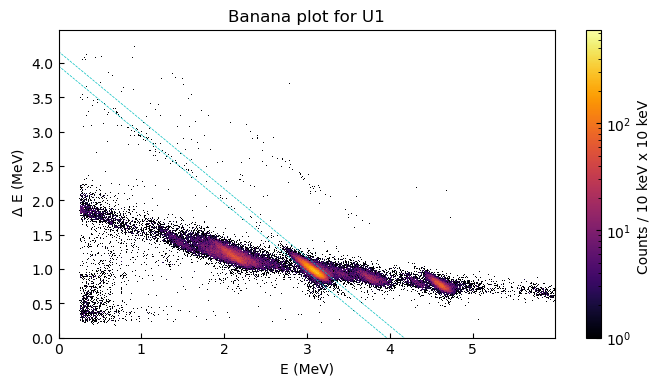

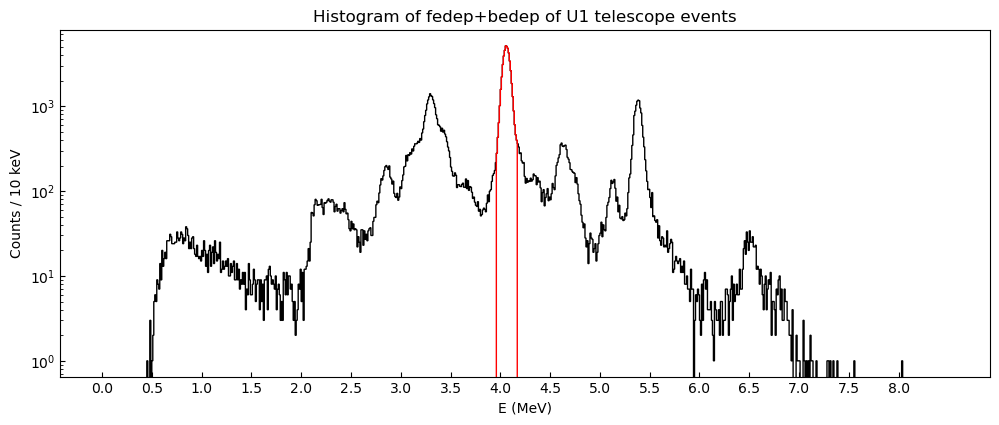

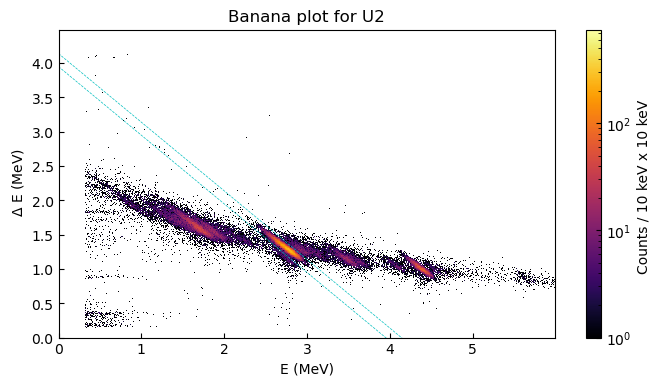

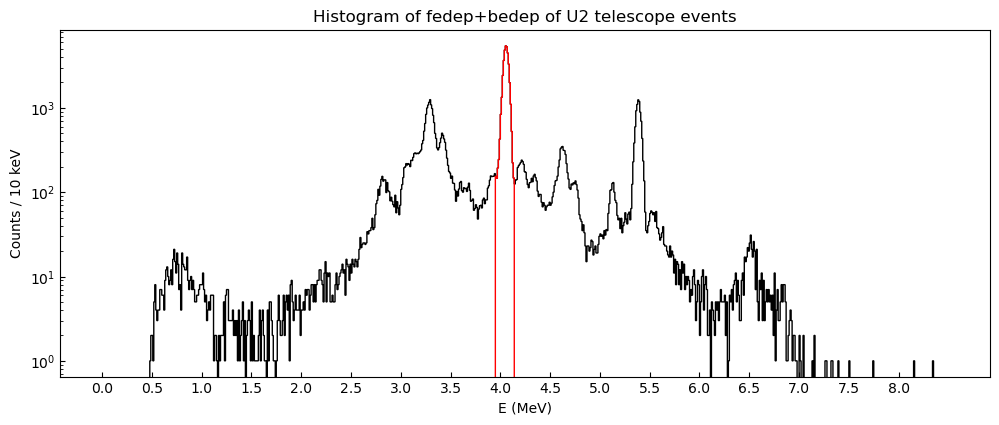

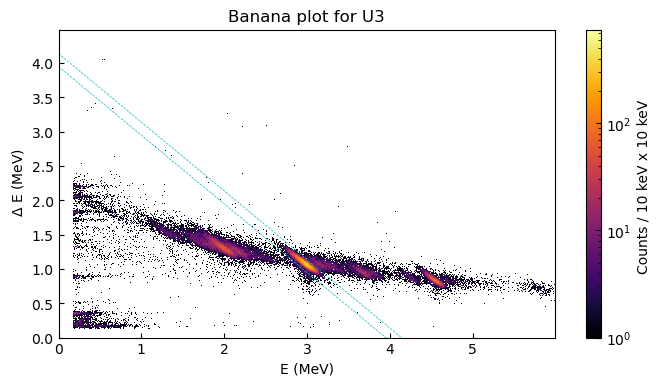

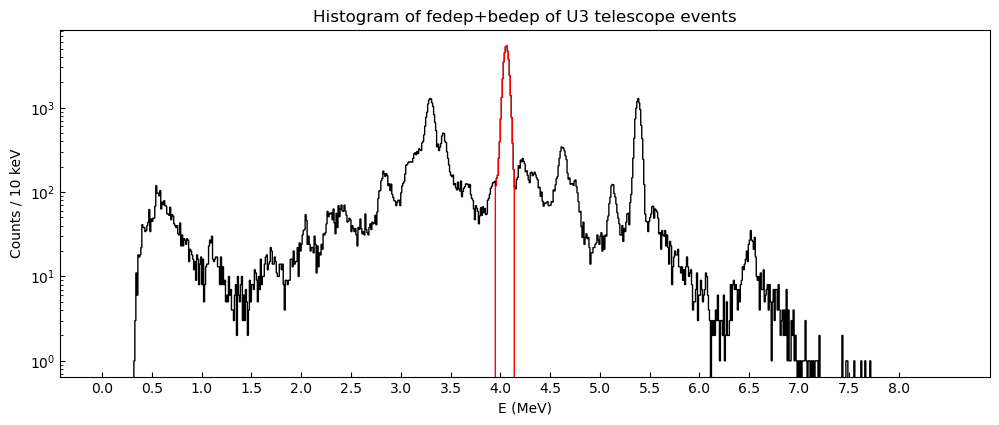

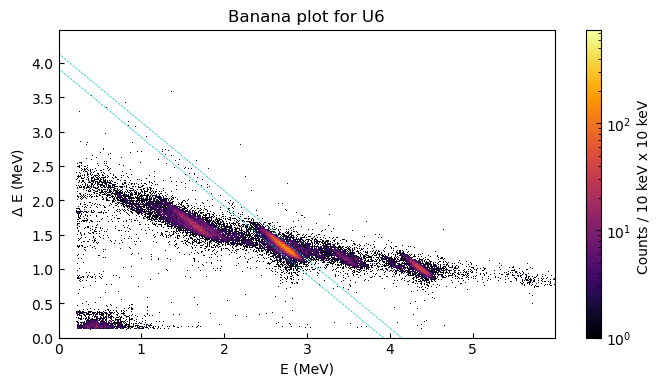

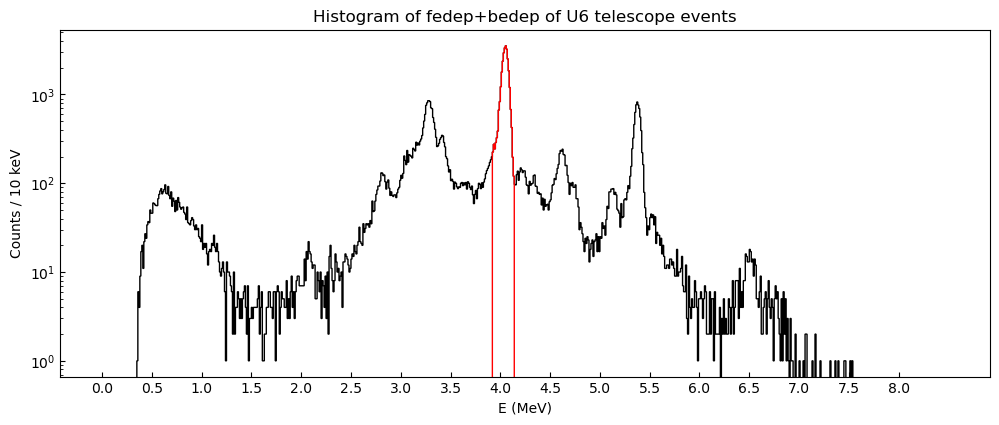

In [8]:

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"




#lowlim= 5.
#uplim = 5.16
lowlim = 3.92
uplim = 4.12
x = np.linspace(0, 6, 400)


ls = [3.96, 3.95, 3.95, 1, 1, 3.92]
us = [4.17, 4.14, 4.14, 1, 1, 4.14]

### Banana plots to get an idea of the amount of events above the banana
## An idea of the size of the anomalous events
for i in range(6):
    y1 = -x + ls[i]
    y2 = -x + us[i] 
    if i==3 or i==4:
        continue
    det = f"id{i}"
    plt.figure(figsize=(8,4))
    plt.hist2d(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"], bins=(np.arange(0, 6, 0.01), np.arange(0, 4.5, 0.01)),
                   cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(vmin=1, vmax=750), rasterized=True)       
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel("E (MeV)")
    plt.ylabel(r" $\Delta$ E (MeV)")
    plt.title(f"Banana plot for U{i+1}")
    plt.plot(x,y1, ls='--', color='c', lw=0.5)
    plt.plot(x,y2, ls='--', color='c', lw=0.5)
 

    plt.plot()


    plt.figure(figsize=(12,4.5))
    æ = [a+b for a,b in zip(data_collection[iso][det]["bEdep"], data_collection[iso][det]["fEdep"]) if a+b>0]
    plt.hist(æ, bins=np.arange(0,8.5,0.01), histtype='step', color='k')
    #plt.hist(data_collection[iso][det]["E"], bins=np.arange(0,8.5,0.01), histtype='step', color='k')

    plt.xlabel("E (MeV)")
    plt.ylabel("Counts / 10 keV")
    plt.yscale('log')
    plt.title(f"Histogram of fedep+bedep of U{i+1} telescope events")
    ø = [m for m in æ if ls[i]<m<us[i]]
    plt.hist(ø, bins=np.arange(0,8.5,0.01), histtype='step', color='r')
    plt.xticks(np.arange(0,8.5,0.5))
    #plt.hist(data_collection[iso][det]["Edep"], bins=np.arange(0,8.5,0.01), histtype='step', color='c')
    #plt.vlines(2.99, 0, 1e2, color='c', ls='--')
    #plt.vlines(3.877, 0, 1e2, color='c', ls='--')
    plt.show()


#### Now run the analysis "bananaexplorer" with the appropriate limits found from the previous plot. These limits are then also written down below in "peaks", "peak_vals" and also write down the number of peaks you wish to analyze

In [4]:

peaks = [(3.92,4.12), (5, 5.16), (5.22, 5.44)]
peak_vals = [4.093, 5.162, 5.415]
nr_peaks = len(peaks)

if nr_peaks != len(peak_vals) and nr_peaks != len(peaks) and len(peaks) != len(peak_vals):
    raise ValueError("The lengths of nr_peaks, peak_vals, and peaks do not match. Please set the appropriate values before continuing.")



def list_ini(n):
    return [[[] for _ in range(3)] for _ in range(n)]


### Values extracted from iso -> all values from base analysis
p_fi = list_ini(nr_peaks); p_bi=list_ini(nr_peaks); p_fedep=list_ini(nr_peaks); p_bedep=list_ini(nr_peaks)
p_app_angles=list_ini(nr_peaks)
p_posx= list_ini(nr_peaks);p_posy= list_ini(nr_peaks);p_posz= list_ini(nr_peaks)

## Values extracted from p_iso -> all values from peak analysis
p_calc_angles=list_ini(nr_peaks)


for j in range(len(peaks)):
    for i in range(3):
        det = f"id{i}"
        ## filling the values from base analysis
        for a,b,c,d,v, px,py,pz in zip(data_collection[iso][det]["fEdep"], data_collection[iso][det]["bEdep"],
                       data_collection[iso][det]["FI"], data_collection[iso][det]["BI"],data_collection[iso][det]["angle"],
                       data_collection[iso][det]["pos.fX"],data_collection[iso][det]["pos.fY"],data_collection[iso][det]["pos.fZ"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_fi[j][i].append(c)
                p_bi[j][i].append(d)
                p_fedep[j][i].append(a)
                p_bedep[j][i].append(b)
                p_app_angles[j][i].append(v)
                p_posx[j][i].append(px)
                p_posy[j][i].append(py)
                p_posz[j][i].append(pz)
            else:
                continue
        for a,b,v in zip(data_collection["p_"+iso][det]["fEdep"], data_collection["p_"+iso][det]["bEdep"],
                       data_collection["p_"+iso][det]["angle"]):
            if peaks[j][0]<=a+b<=peaks[j][1]:
                p_calc_angles[j][i].append(v)



#### Fedep spectra of the different peaks and detectors
#### Below "newcuts" is introduced which are cuts that are located lower than the cut imposed by the thickness the figures also display this cut. This is used to go from the overall data of angle=0 and an even lower cut on fedep.

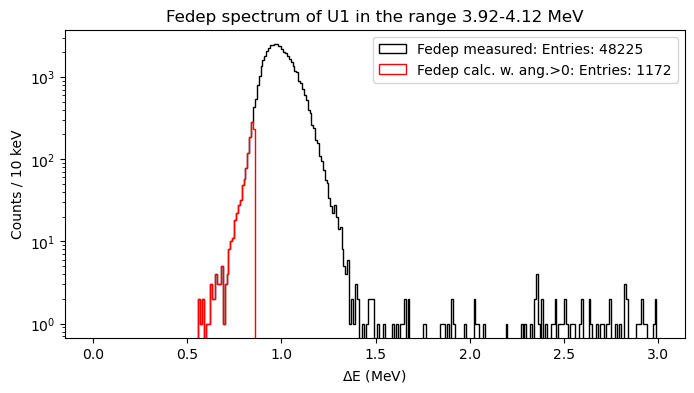

0.5656052246042095


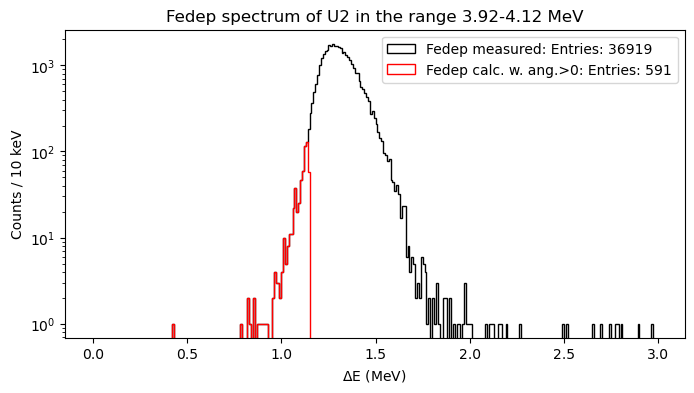

0.42794510852875517


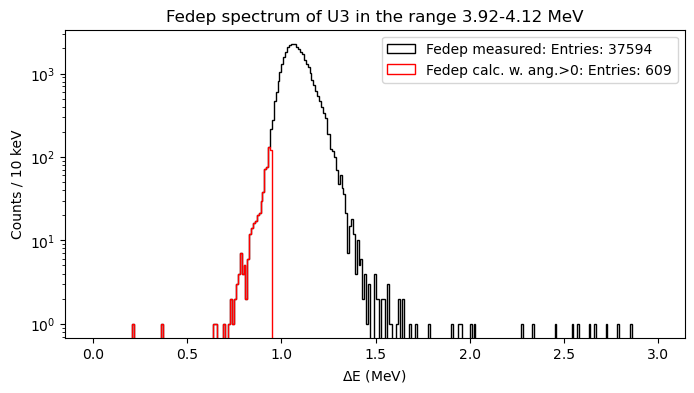

0.21609988271720043


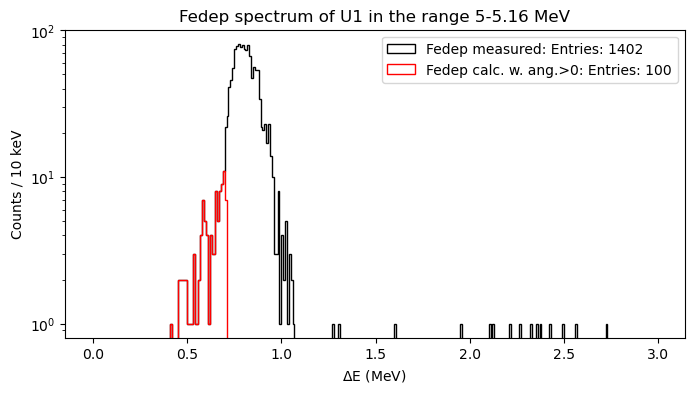

0.41792655127429157


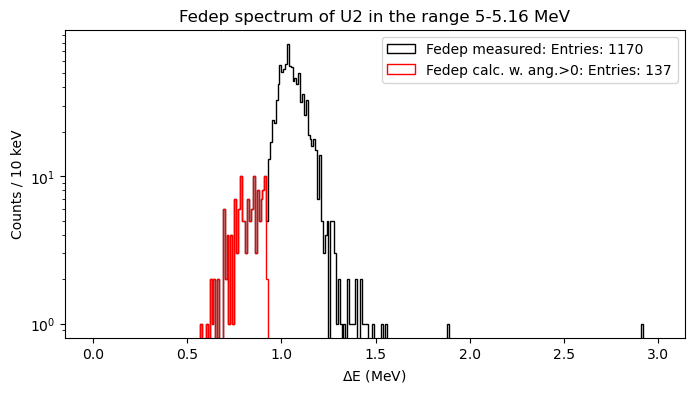

0.5764195753245996


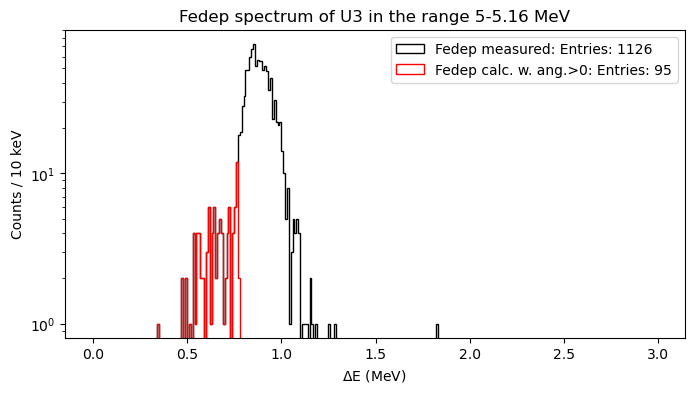

0.34635847668128517


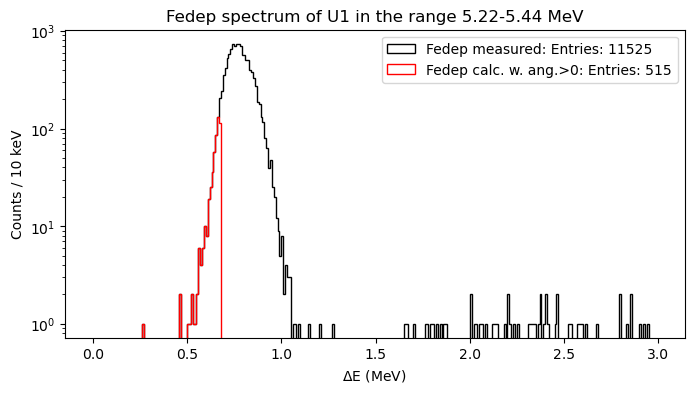

0.26506593491198


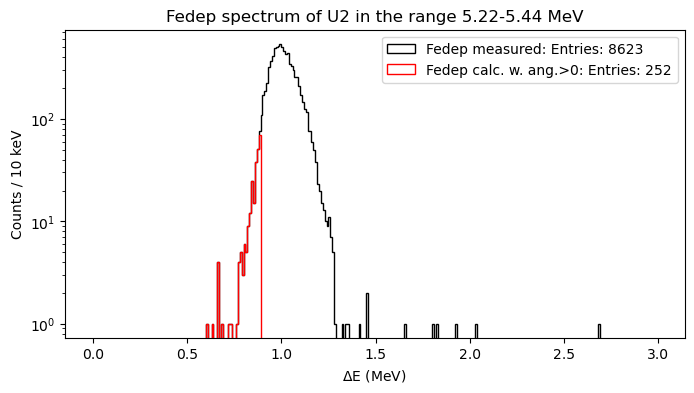

0.6031060383796122


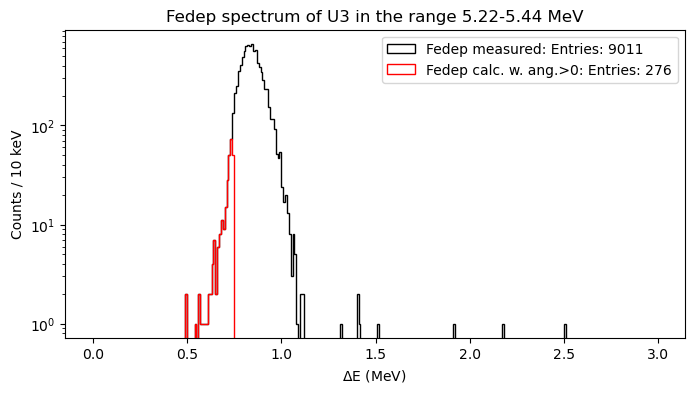

0.49406609721758865


In [5]:
newcuts = [[0.92,0.755,0.727],[1.23,0.993,0.956],[1.017,0.83,0.8]]
for j in range(len(peaks)):
    for i in range(3):
        plt.figure(figsize=(8,4))
        plt.xlabel(r"$\Delta$E (MeV)")
        plt.ylabel("Counts / 10 keV")
        plt.yscale('log')
        cut_fedep = newcuts[i][j]*0.93
        calc_fedeps = [a for a,v in zip(p_fedep[j][i],p_calc_angles[j][i]) if a<cut_fedep] 
        plt.title(f"Fedep spectrum of U{i+1} in the range {peaks[j][0]}-{peaks[j][1]} MeV")
        plt.hist(p_fedep[j][i], bins=np.arange(0,3, 0.01), histtype='step', color='k', label=f"Fedep measured: Entries: {len(p_fedep[j][i])}")
        plt.hist(calc_fedeps, bins=np.arange(0,3, 0.01), histtype='step', color='r', label=f"Fedep calc. w. ang.>0: Entries: {len(calc_fedeps)}")#({len(p1_f[i])/len(p1_fedep[i])*100:.2f}%)")
        plt.legend()
        plt.show()
        print(np.min(calc_fedeps))

#### Plot of simulated angle distributions compared to the apparent angle distributions of the different detectors and the calculated angle distributions.

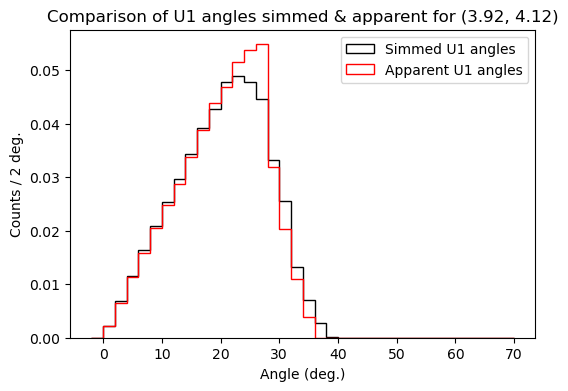

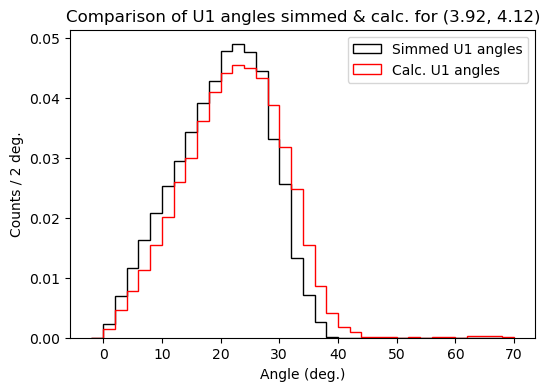

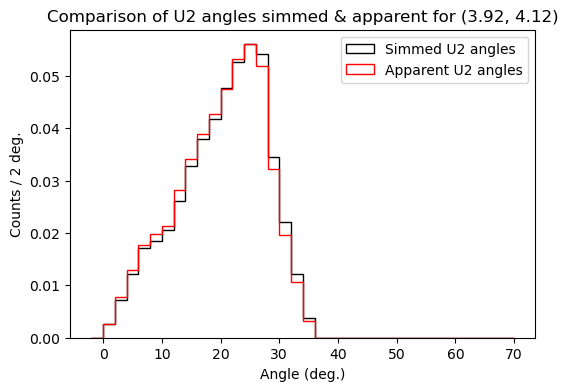

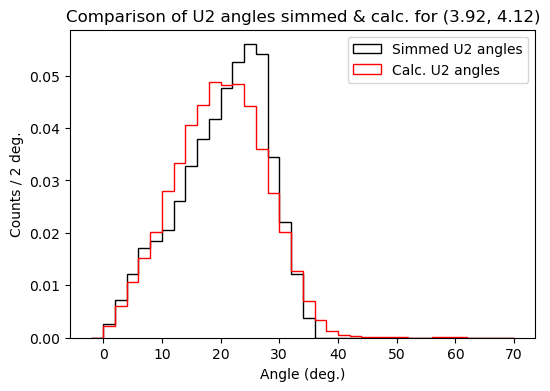

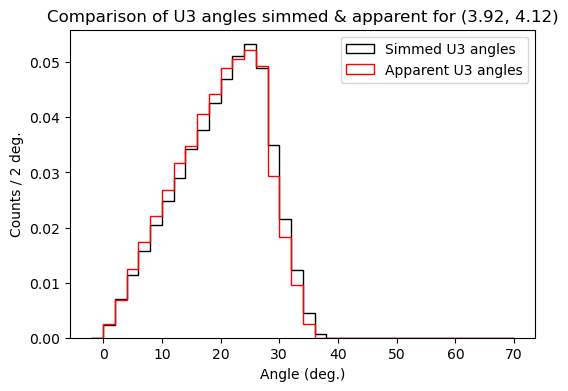

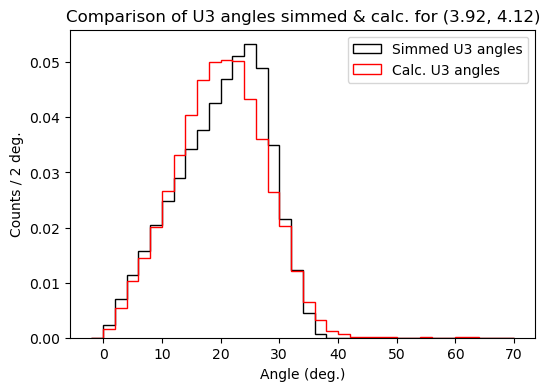

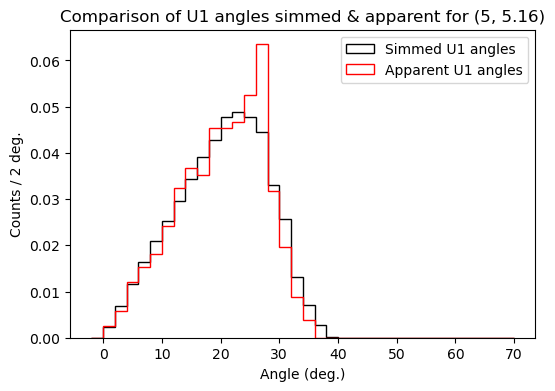

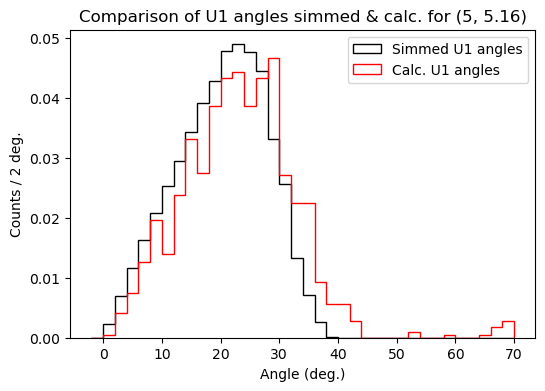

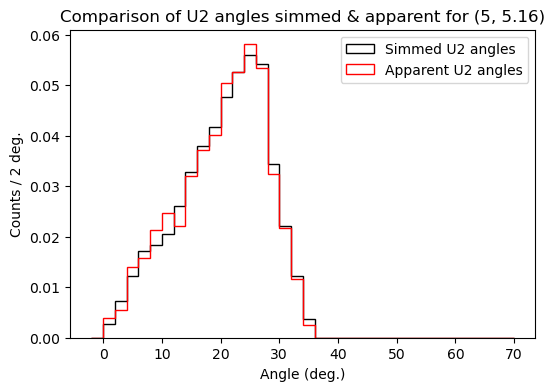

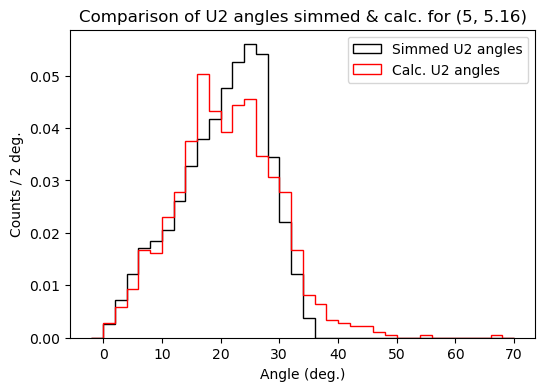

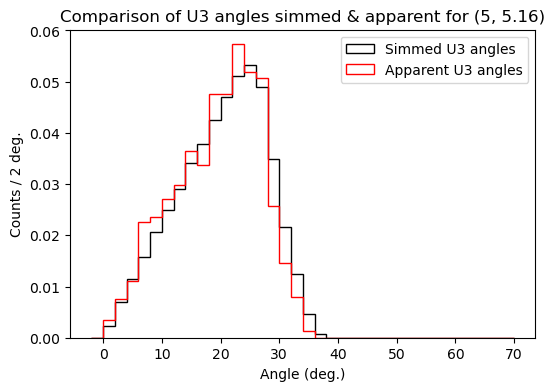

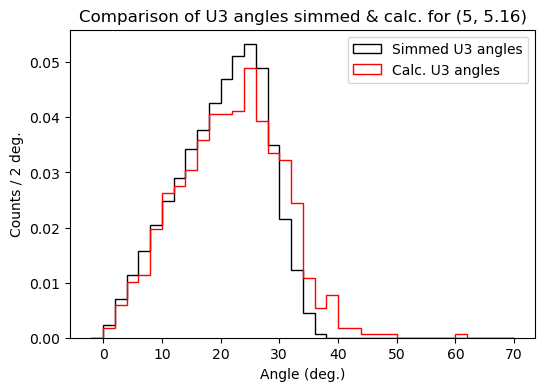

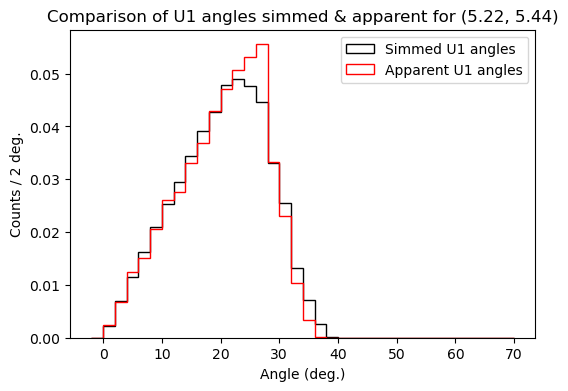

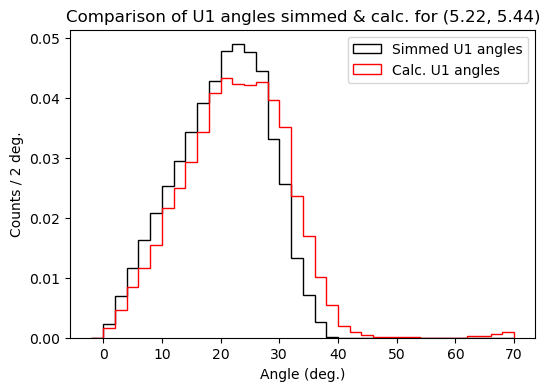

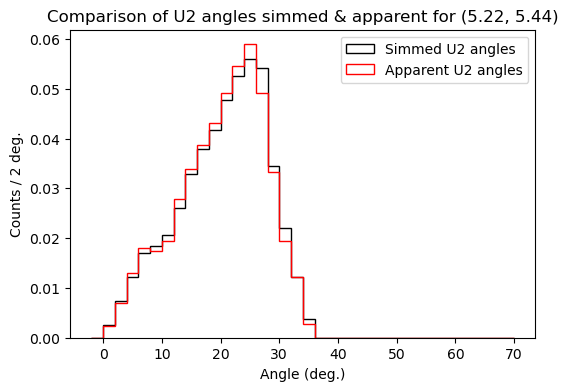

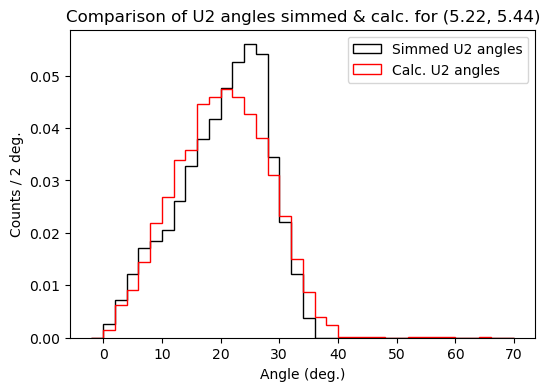

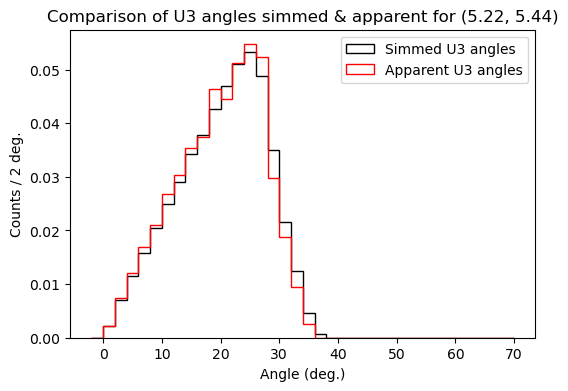

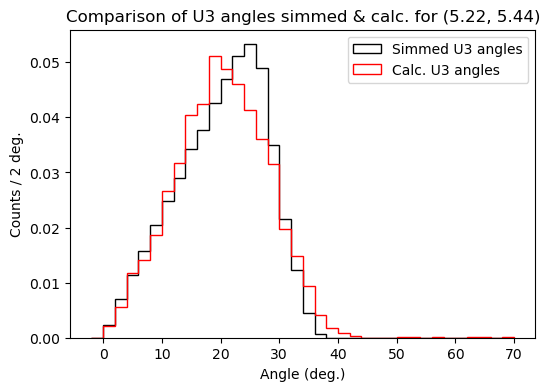

In [6]:
#angfiles = ["U1Ang.dat", "U2Ang.dat", "U3Ang.dat"]
angfiles = ["U1testbeam.dat", "U2testbeam.dat", "U3testbeam.dat"]
labs = ["U1 angles", "U2 angles", "U3 angles"]
### can expand to multiple peaks

for j,val in zip(range(len(peaks)), peaks):
    for i, a, l in zip(range(3),angfiles,labs):
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        fi, bi, angs, n = np.loadtxt(simpath+a, unpack=True)
        angs = np.rad2deg(angs)
        angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(p_app_angles[j][i], bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Apparent "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & apparent for {val}")
        ###
        plt.figure(figsize=(6,4))
        plt.xlabel("Angle (deg.)")
        plt.ylabel("Counts / 2 deg.")
        pa = [a for a in p_calc_angles[j][i] if a>0]
        plt.hist(angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True, label="Simmed "+l)
        plt.hist(pa, bins=np.arange(-2,72,2), histtype='step', color='r', density=True, label="Calc. "+l)
        plt.legend()
        plt.title(f"Comparison of " +l + f" simmed & calc. for {val}")


#### Summed hit patterns of the different detectors, the mask can be changed from angle=0 cut and newcuts cut.

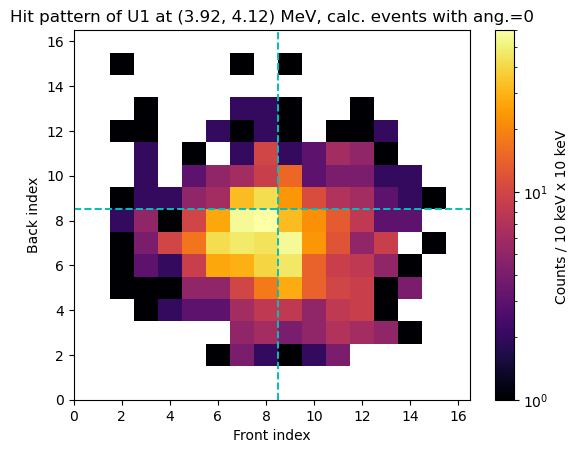

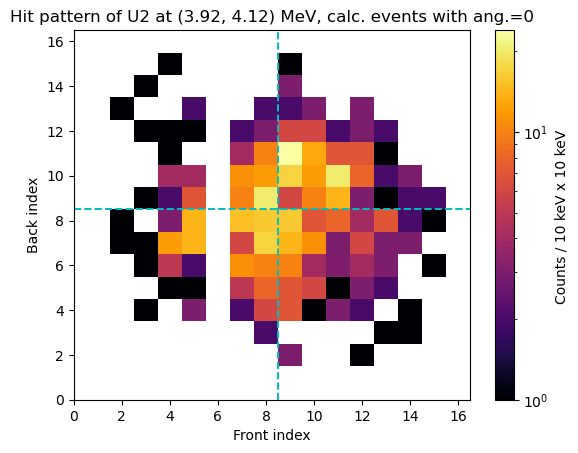

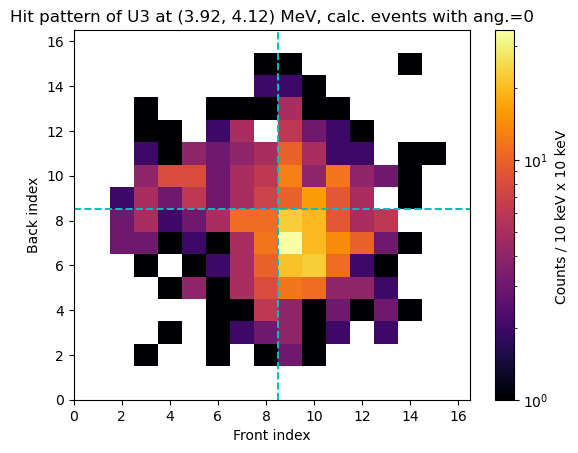

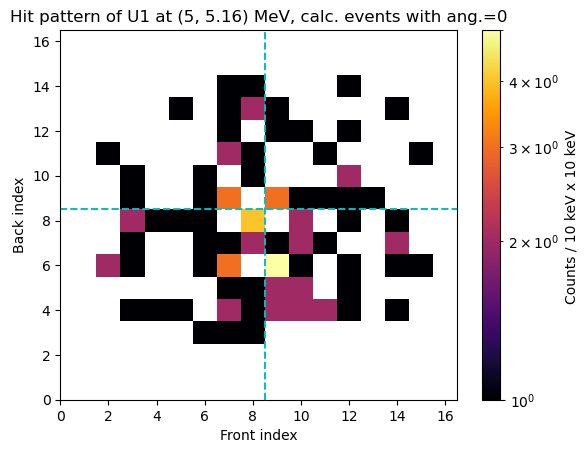

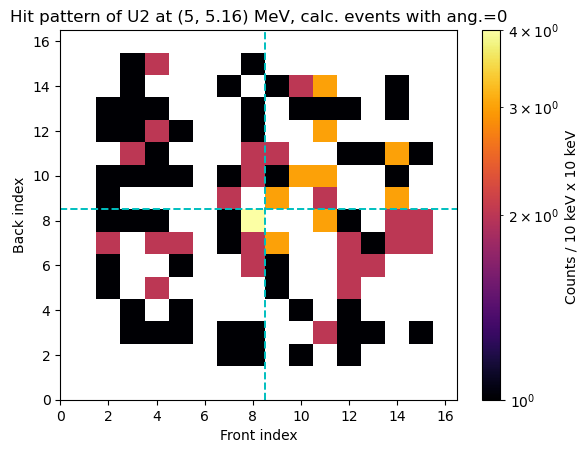

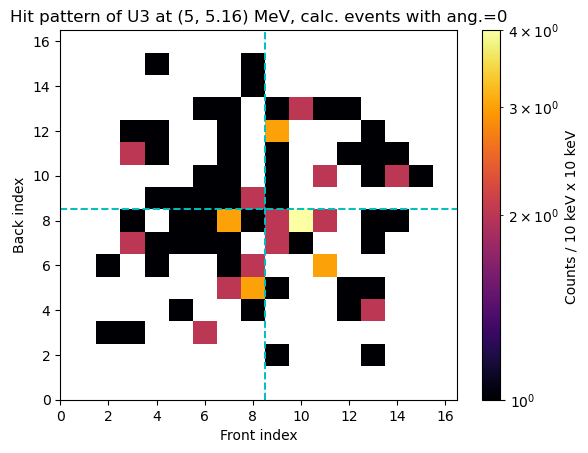

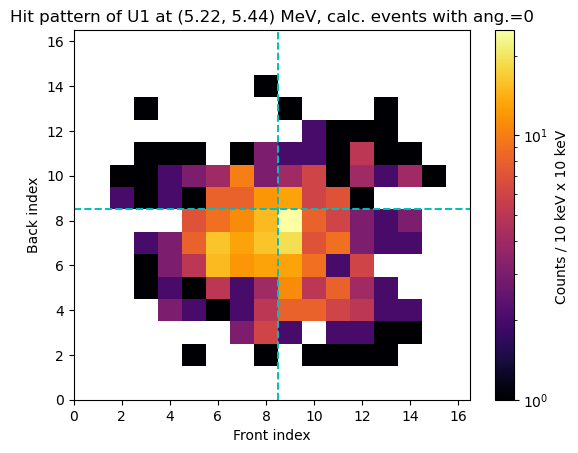

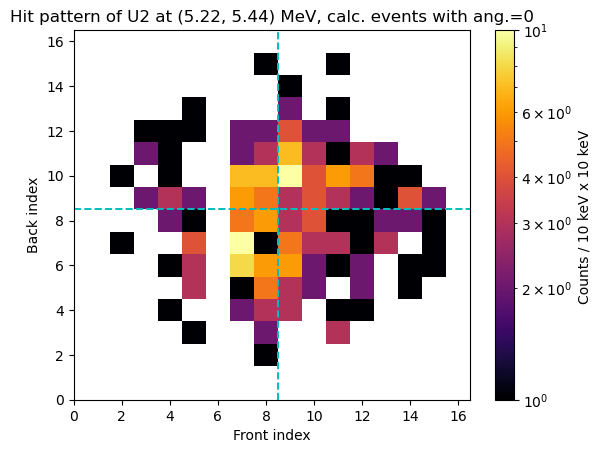

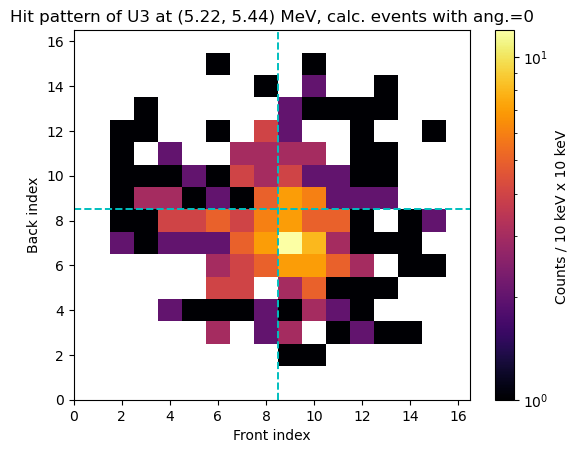

In [7]:
FIS = [[] for i in range(3)]; BIS = [[] for i in range(3)]
hists = list_ini(nr_peaks)

for j in range(len(peaks)):
    for i in range(3):
        calc_angles = np.array(p_calc_angles[j][i])#p1_angs[i])
        cut_fedep = newcuts[i][j]*0.93 ### !!!!!!!!!!!
        #mask = (calc_angles ==0) ###3 !!!!!!
        fs = np.array(p_fi[j][i])#p1_angs_fi[i])
        bs = np.array(p_bi[j][i])#p1_angs_bi[i])
        fes = np.array(p_fedep[j][i])
        mask = (fes < cut_fedep) ###!!!!!!!!
        fs = fs[mask]
        bs = bs[mask]
        plt.figure()
        plt.hist2d(fs, bs, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
            cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        hist= np.histogram2d(fs, bs, bins=(np.arange(1.5, 16.5, 1), np.arange(1.5,16.5,1)))
        hists[j][i] = hist
        plt.title(f"Hit pattern of U{i+1} at {peaks[j]} MeV, calc. events with ang.=0")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
        plt.xticks(np.arange(0,18, 2))
        plt.yticks(np.arange(0,18,2))
        plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
        plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')

        FIS[i].append(fs); BIS[i].append(bs)
        plt.show()


#### Same plot as above, but now the weighted centroid has been calculated, however this is not an ideal quantity, but the values gotten from this calculation is what has been used to make the newbeam.dat files from the angle comparisons above

Weighted most intense position for U1: Front index = 8.36, Back index = 7.17


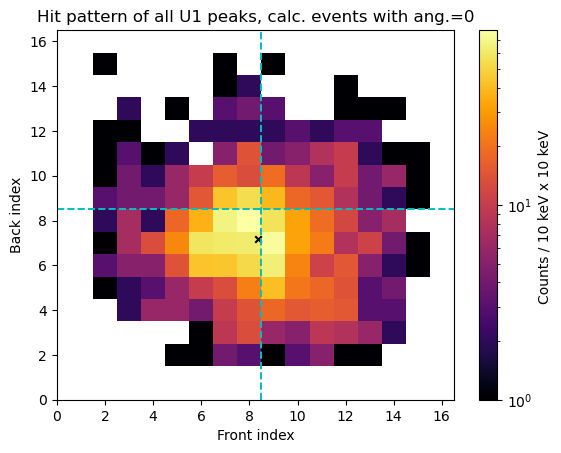

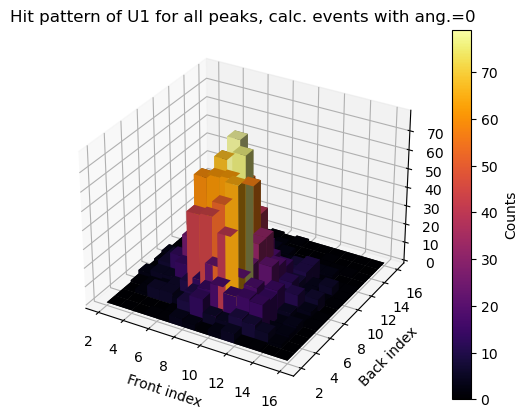

Weighted most intense position for U2: Front index = 8.75, Back index = 8.4


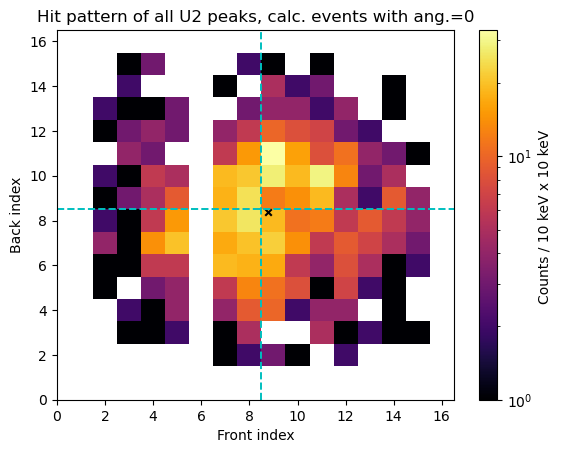

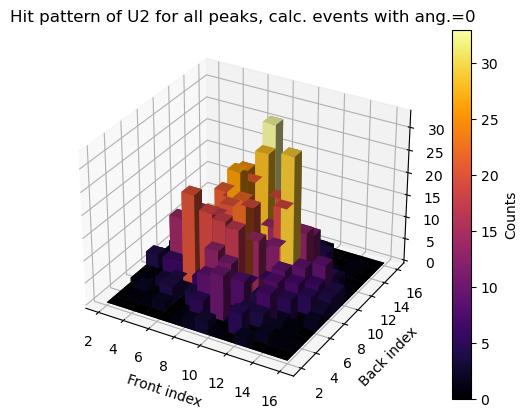

Weighted most intense position for U3: Front index = 8.6, Back index = 7.87


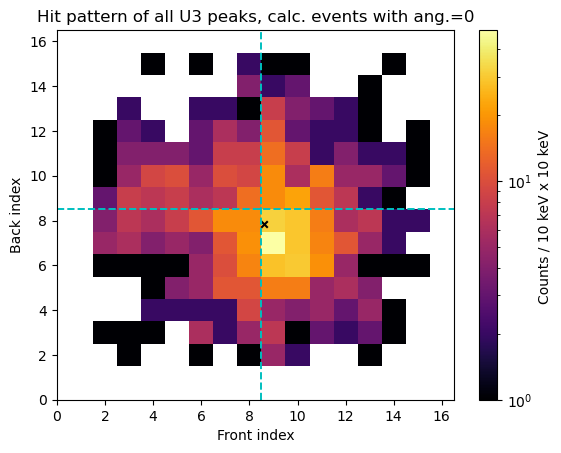

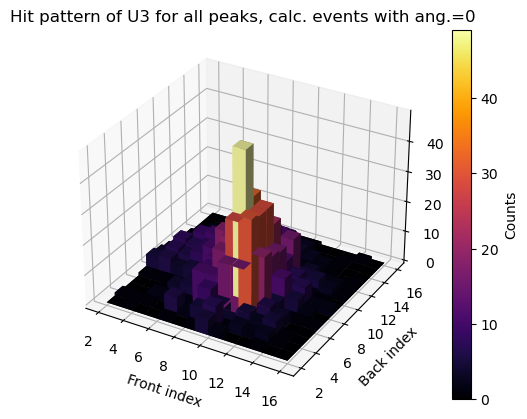

In [8]:
from mpl_toolkits.mplot3d import Axes3D

for i in range(3):
    plt.figure()
    #target_fi = [f for f,b in zip(np.array(ak.flatten(FIS[i])),np.array(ak.flatten(BIS[i]))) if 7<=f<=10 and 6<=b<=11]
    #target_bi = [b for f,b in zip(np.array(ak.flatten(FIS[i])),np.array(ak.flatten(BIS[i]))) if 7<=f<=10 and 6<=b<=11]
    plt.hist2d(np.array(ak.flatten(FIS[i])), np.array(ak.flatten(BIS[i])), bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
    cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    #plt.hist2d(target_fi, target_bi, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
    #cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    
    hist, x_edge, y_edge = np.histogram2d(np.array(ak.flatten(FIS[i])), np.array(ak.flatten(BIS[i])), bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)))
    x_center = (x_edge[:-1] + x_edge[1:])/2
    y_center = (y_edge[:-1] + y_edge[1:]) /2
    #print(y_center[:,None]*hist)
    x_centroid = np.sum(hist * x_center[:,None]) / np.sum(hist) # x_center[:,None] reshapes it from a row vector to a column vector so it can be properly multiplied with hist
    y_centroid = np.sum(hist * y_center[None,:]) / np.sum(hist)
    
    print(f"Weighted most intense position for U{i+1}: Front index = {np.round(x_centroid,2)}, Back index = {np.round(y_centroid,2)}")
    plt.title(f"Hit pattern of all U{i+1} peaks, calc. events with ang.=0")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.xticks(np.arange(0,18, 2))
    plt.yticks(np.arange(0,18,2))
    plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
    plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
    plt.scatter(x_centroid, y_centroid, color='k', marker='x', s=22)
    
    
    hist, xedges, yedges = np.histogram2d(np.array(ak.flatten(FIS[i])), np.array(ak.flatten(BIS[i])), bins=(np.arange(1.5, 16.5, 1), np.arange(1.5, 16.5, 1)))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    dx = dy = 1 * np.ones_like(zpos)
    dz = hist.ravel()
    norm = mpl.colors.Normalize(vmin=dz.min(), vmax=dz.max())
    colors = plt.cm.inferno(norm(dz))

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')

    ax.set_title(f"Hit pattern of U{i+1} for all peaks, calc. events with ang.=0")
    ax.set_xlabel('Front index')
    ax.set_ylabel('Back index')
    ax.set_zlabel('Counts')
    mappable = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.inferno)
    mappable.set_array(dz)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('Counts')

    plt.show()



In [129]:
## manual calculations of pixel position -> target position
one_pix_x = 2.12 ##mm on target
one_pix_y = 3 #mm on target
BI_85 = 0.212 #mm on target
BI_cent = 8.5
(8.75*one_pix_x)-(BI_cent*one_pix_x)-BI_85, (7.76*3-(8.5*3+0.15)), 0.1*3+0.15


(0.31800000000000117, -2.3699999999999974, 0.45000000000000007)

#### So the below code is in general less than ideal, but the main takeaway is the manual calculation of target_pos_x that has been later implemented into the analysis script. So this can be removed if the data has been read instead. The max hit pattern pixels analysis didnt bear any fruit and should be ignored. However for now it is a part of my thought process and therefore stays

In [9]:
### i want to find the most intense pixel locations, this is ofcourse not very stringent and i should probably run
# it through a minimizer, ideally.

highhits = [220, 145, 160] ## array that states the number of counts which the most intense pixels are above
## perhaps this should be determined dynamically??
target_posx = list_ini(nr_peaks)
target_posy = list_ini(nr_peaks)
possx = list_ini(nr_peaks)
pixels = [(8,7), (10,10), (9,7)]


dirvecs = [(1,0,1), (1,0,-1), (-1,0,-1)]

maxf = list_ini(nr_peaks);maxb=list_ini(nr_peaks)
for j in range(len(peaks)):
    for h,m in zip(range(3),highhits):#for each weight matrix for the respective histogram
        
            for v in range(len(hists[j][h][0])): # for each FI rows containing all 16 BI values
                for i in range(len(hists[j][h][0][v])): #for each BI in the given FI row
                    if hists[j][h][0][v][i]>m: #if the value for the weight matrix is higher than the specifed limit we save the pixels
                        
                        maxf[j][h].append((hists[j][h][1][v]+hists[j][h][1][v+1])/2)
                        maxb[j][h].append((hists[j][h][2][i]+hists[j][h][2][i+1])/2)
    #print(maxf,maxb)

    for i in range(3):
        calc_angles = np.array(p_calc_angles[j][i])#p1_angs[i])
        cut_fedep = newcuts[i][j]*0.93
        #mask = (calc_angles ==0)
        fs = np.array(p_fi[j][i])#p1_angs_fi[i])
        bs = np.array(p_bi[j][i])#p1_angs_bi[i])
        fes = np.array(p_fedep[j][i])
        mask = (fes < cut_fedep)
        fs = fs[mask]
        bs = bs[mask]
        pxs = np.array(p_posx[j][i])[mask]
        pys = np.array(p_posy[j][i])[mask]
        pzs = np.array(p_posz[j][i])[mask]

        filt_f = [f for f,b in zip(fs,bs) if (f,b) in zip(maxf[j][i],maxb[j][i])]
        filt_b = [b for f,b in zip(fs,bs) if (f,b) in zip(maxf[j][i],maxb[j][i])]
        filt_pxs = [x for f,b,x in zip(fs,bs,pxs)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        filt_pys = [y for f,b,y in zip(fs,bs,pys)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        filt_pzs = [z for f,b,z in zip(fs,bs,pzs)]# if (f,b) in [pixels[i]]]#zip(maxf[j][i],maxb[j][i])]
        
        for x,y,z in zip(filt_pxs,filt_pys,filt_pzs):
            #if i>1:
            #    Xpos = x-abs(z+0.3)
            #else:
            #    Xpos = abs(z+0.3)+x
            vec = dirvecs[i]
            
            somev = (-0.3-z)/vec[2]
            
            Xpos = x+somev*vec[0]
            #print("x",x, "z",z, "v", somev, "xpos",Xpos)
            target_posx[j][i].append(Xpos)
            target_posy[j][i].append(y)
            possx[j][i].append(x)
        
        """
        plt.figure()
        plt.hist2d(filt_f, filt_b, bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
           cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
        hist= np.histogram2d(filt_f, filt_b, bins=(np.arange(1.5, 16.5, 1), np.arange(1.5,16.5,1)))
        #print(hist[0])
        
        plt.title(f"Hit pattern of U{i+1} at {peaks[j]} MeV, calc. events with ang.=0")
        cbar = plt.colorbar()
        cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")
        plt.xlabel('Front index')
        plt.ylabel('Back index')
        plt.xticks(np.arange(0,18, 2))
        plt.yticks(np.arange(0,18,2))
        plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
        plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')

        plt.show()
        """


#### Plotting the calculated target_pos_x values -> havent used them for anything really

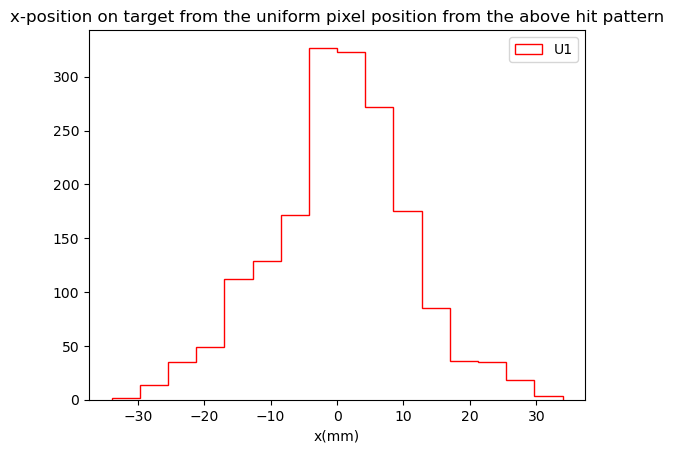

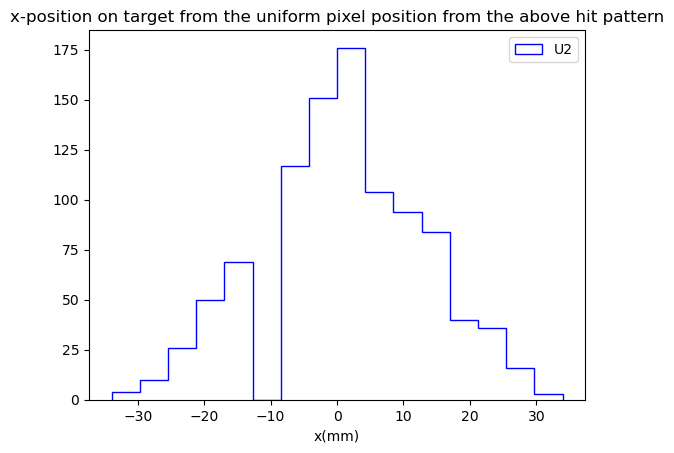

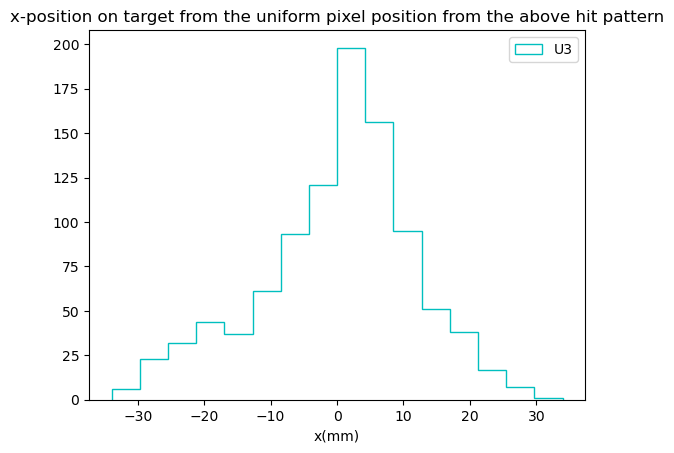

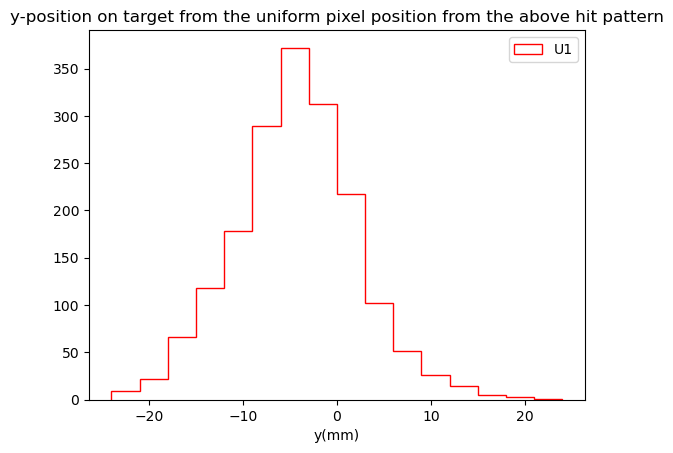

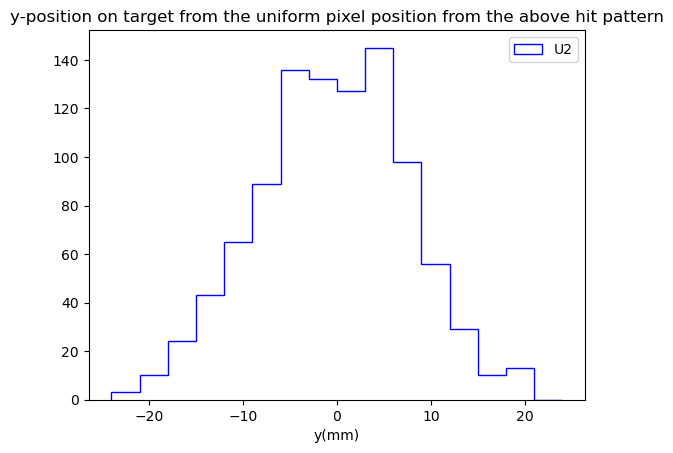

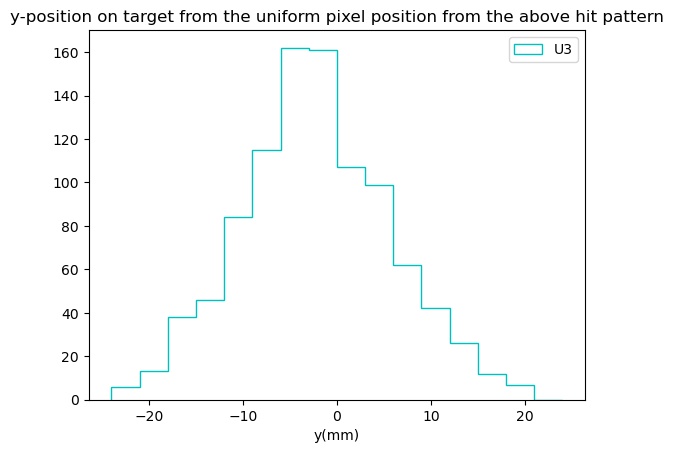

In [10]:

cols = ["r", "b", "c"]
pixels = [(8,7), (10,10), (9,7)]
#for i in range(3):
    #print(np.min(possx[0][i]), np.max(possx[0][i]))
allpeaks_x = [[] for _ in range(3)]
allpeaks_y = [[] for _ in range(3)]
# Accumulate data for each i index across all j values
for j in range(len(peaks)):
    for i in range(3):
        allpeaks_x[i].extend(target_posx[j][i])
        allpeaks_y[i].extend(target_posy[j][i])

#for j in range(len(peaks)):
for i in range(3):
    plt.figure()
    plt.hist(allpeaks_x[i], bins = np.arange(-33.94113, 33.94113 + 4.24264125, 4.24264125),histtype='step', color=cols[i], label=f"U{i+1}")
    plt.legend()
    plt.title("x-position on target from the uniform pixel position from the above hit pattern")
    plt.xlabel("x(mm)")

for i in range(3):
    plt.figure()
    plt.hist(allpeaks_y[i], bins=np.arange(-24,24+3,3),histtype='step', color=cols[i], label=f"U{i+1}")
    plt.legend()
    plt.xlabel("y(mm)")
    plt.title("y-position on target from the uniform pixel position from the above hit pattern")
 

#### Simulated hit pattern plots

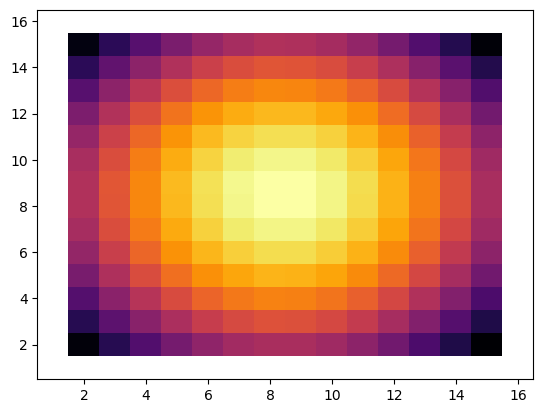

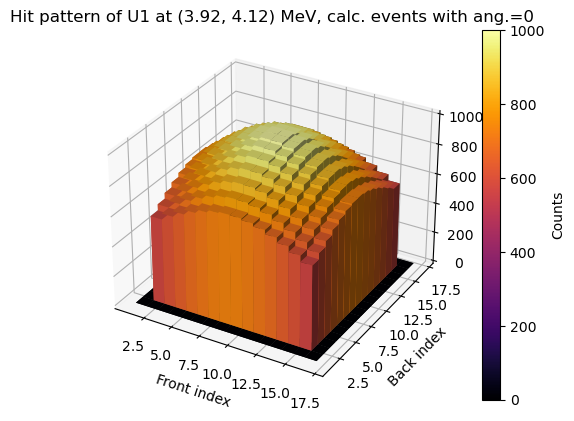

In [11]:
FI_list = list_ini(nr_peaks);BI_list = list_ini(nr_peaks)
fi, bi, angs, n = np.loadtxt(simpath+"U1Ang.dat", unpack=True)

angs = np.rad2deg(angs)
Angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
#plt.hist(Angs, bins=np.arange(-2,72,2), histtype='step', color='k', density=True)

masked = (angs < 40)
fis = fi[masked]; bis = bi[masked]; ns = n[masked]
for æ in range(2,16): #we exclude FI=1 and FI =16
    mask_fi = (fis==æ)
    if not np.any(mask_fi):
        continue
    else:
        masked_fi = fis[mask_fi]
        masked_bi = bis[mask_fi]
        masked_n = ns[mask_fi]
    for ø in range(2,16): #we exclude BI=1 and BI=16
        mask_bi = (masked_bi == ø)       
        if not np.any(mask_bi):
            continue
        else:   
            doubmasked_n = masked_n[mask_bi] ## list of n's, they should all have the same value
            for å in range(0,int(doubmasked_n[0])):
                FI_list[0][0].append(æ)
                BI_list[0][0].append(ø)
plt.figure()
plt.hist2d(np.array(FI_list[0][0])-0.5, np.array(BI_list[0][0])-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)),
cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
plt.show()
hist, xedges, yedges = np.histogram2d(np.array(FI_list[0][0])-0.5, np.array(BI_list[0][0])-0.5, bins=(np.arange(0.5, 17.5, 1), np.arange(0.5,17.5,1)))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xpos, ypos = np.meshgrid(xedges[:-1] + 0.5, yedges[:-1] + 0.5, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0
dx = dy = 1 * np.ones_like(zpos)
dz = hist.ravel()
norm = mpl.colors.Normalize(vmin=dz.min(), vmax=dz.max())
colors = plt.cm.inferno(norm(dz))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors, zsort='average')
ax.set_title(f"Hit pattern of U{1} at {peaks[0]} MeV, calc. events with ang.=0")
ax.set_xlabel('Front index')
ax.set_ylabel('Back index')
ax.set_zlabel('Counts')
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.inferno)
mappable.set_array(dz)
cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label('Counts')
plt.show()

#### Script used to iterate over different "Angles" calls with different parameters, not used for anything important but relevant piece of code, so it stays

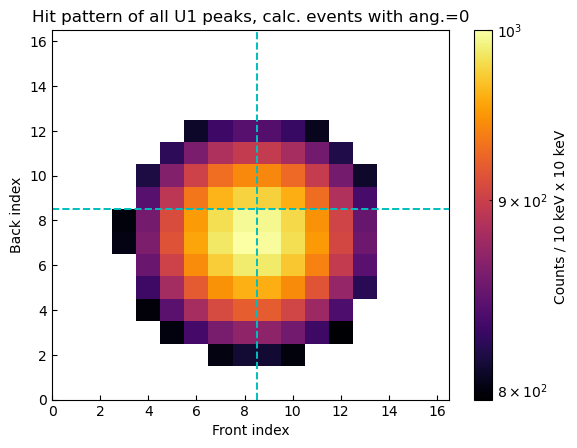

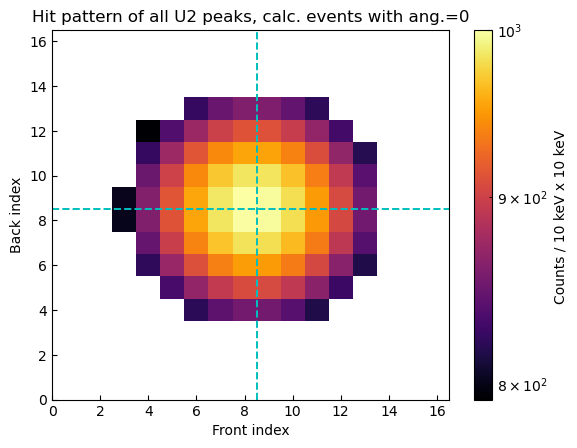

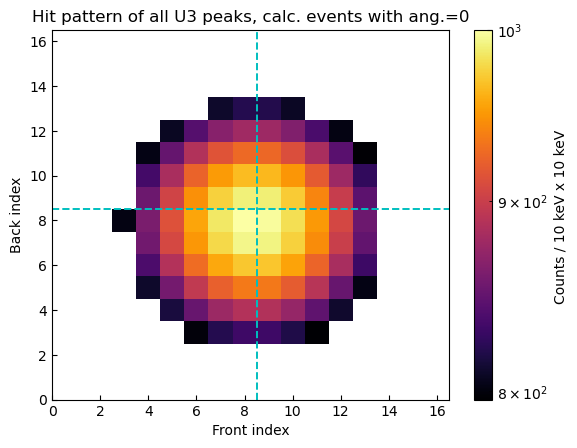

In [133]:
import subprocess
xs = [0.51, -0.31, 0.466]
ys = [-4.14, -0.45, -2.1]
#strength = [7, 10, 9]
simdir = "/home/haue/repositories/Masters/simdata/"
angles = [[[] for _ in range(3)] for _ in range(3)]
FI_list = [[[] for _ in range(3)] for _ in range(3)]
BI_list = [[[] for _ in range(3)] for _ in range(3)]
cols = ['b', 'c', 'r']
cm = 1
var = "xy"
for i in range(3):
    curdir = os.getcwd()
    os.chdir(simdir)    
    for x,y,j in zip(xs,ys,range(len(xs))):
        filename = "U%dtestspot_%d%s.dat" % (i+1, x, var)
        
        f = open(filename, "w")
        subprocess.call(["Angles", "-dU%d" % (i+1), f"-i17", "-ssetup.json", "-ttarget.json", "-mmatcher.json"
                                , "-n%d" % (1000), "-ay", "-x%d" % (x), "-y%d" % (y)], cwd="/home/haue/repositories/Masters/setup/", stdout=f)
        f.close()
        fi, bi, angs, n = np.loadtxt(filename, unpack=True)
        angs = np.rad2deg(angs)
        Angs = [a for a,f,b in zip(angs, fi, bi) if f>1 and f<16 and b>1 and b<16]
        angles[i][j].append(Angs)
        masked = (angs < 20)
        fis = fi[masked]; bis = bi[masked]; ns = n[masked]
        for æ in range(2,16): #we exclude FI=1 and FI =16
            mask_fi = (fis==æ)
            if not np.any(mask_fi):
                continue
            else:
                masked_fi = fis[mask_fi]
                masked_bi = bis[mask_fi]
                masked_n = ns[mask_fi]
            for ø in range(2,16): #we exclude BI=1 and BI=16
                mask_bi = (masked_bi == ø)       
                if not np.any(mask_bi):
                    continue
                else:   
                    doubmasked_n = masked_n[mask_bi] ## list of n's, they should all have the same value
                    for å in range(0,int(doubmasked_n[0])):
                        FI_list[i][j].append(æ)
                        BI_list[i][j].append(ø)     
    os.chdir(curdir)
  
for i in range(3):
    plt.figure()  
    plt.hist2d(FI_list[0][i], BI_list[0][i], bins=(np.arange(1.5, 17.5, 1), np.arange(1.5,17.5,1)),
    cmap=plt.cm.inferno, norm=mpl.colors.LogNorm(), rasterized=True)
    #hist= np.histogram2d(fs, bs, bins=(np.arange(1.5, 16.5, 1), np.arange(1.5,16.5,1)))
    #hists[j][i] = hist
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f"Counts / 10 keV x 10 keV ")

    plt.title(f"Hit pattern of all U{i+1} peaks, calc. events with ang.=0")
    plt.xlabel('Front index')
    plt.ylabel('Back index')
    plt.xticks(np.arange(0,18, 2))
    plt.yticks(np.arange(0,18,2))
    plt.vlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
    plt.hlines(8.5, 0, 16.5, ls='--', lw=1.4, color='c')
